In [2]:
import cudaq
import numpy as np
import scipy
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
data = mnist['data']
labels = np.array(mnist['target'], dtype=np.int8)
        

labels_zero = labels[labels==0] 
labels_one = labels[labels==1] 
binary_labels = np.hstack((labels_zero, labels_one))
digits_zero = data[labels==0]
digits_one = data[labels==1]
binary_digits = np.vstack((digits_zero, digits_one))
        
pca = PCA(n_components=4)
sc = StandardScaler()
binary_digits = sc.fit_transform(binary_digits)
data = pca.fit_transform(binary_digits)
data = (data-np.min(data))/(np.max(data)-np.min(data))


x_train, x_test, y_train, y_test = train_test_split(data, binary_labels, test_size=0.2)

x_train=x_train[0:500]
x_test=x_test[0:200]
y_train=y_train[0:500]
y_test=y_test[0:200]

In [4]:
cudaq.set_target("nvidia")

qubit_count = 4

@cudaq.kernel
def kernel(angles: list[float]):
    # Allocate a qubit that is initialised to the |0> state.
    qubit = cudaq.qvector(qubit_count)

    # Define gates and the qubits they act upon.
    for i in range(qubit_count):
        ry(angles[i], qubit[i])
    
    for i in range(qubit_count-1):
        x.ctrl(qubit[i], qubit[i+1])

# Our hamiltonian will be the Z expectation value of our qubit.
hamiltonian = cudaq.spin.z(0)

# Initial gate parameters which intialize the qubit in the zero state
init_parameters = [0.0,0.0,0.0,0.0]

In [5]:
cost_values = []

def cost(parameters):
    expectation_value = cudaq.observe(kernel, hamiltonian, parameters).expectation()
    #print(expectation_value)

    return expectation_value

def callback(xk):
    cost_values.append(cost(xk))

result_vqe=scipy.optimize.minimize(cost,init_parameters,method='COBYLA', callback=callback, tol=1e-5)
print('Final energy: ', result_vqe.fun)
print('Opt. param: ', result_vqe.x)

Final energy:  -0.9999998986142378
Opt. param:  [ 3.14164925  0.02328306 -0.00978729  0.15900816]


Text(0, 0.5, 'Cost Value')

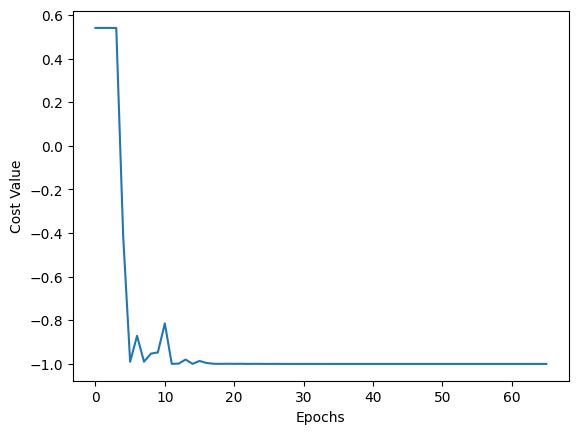

In [6]:
import matplotlib.pyplot as plt

x_values = list(range(len(cost_values)))
y_values = cost_values

plt.plot(x_values, y_values)

plt.xlabel("Epochs")
plt.ylabel("Cost Value")